In [1]:
import os
from DNASkittleUtils.DDVUtils import pp
import csv
from collections import defaultdict
from csv import DictReader
from pandas import read_csv
from itertools import chain
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [2]:
liz = read_csv("GOenrich_db/lizzy_ash_ks.csv", sep='\t')
liz = liz[liz['Ks'] < 20]  # remove a couple bad values

20865 pairs


In [3]:
wgd_recent = (liz['Ks'] > 0.16) & (liz['Ks'] < 0.38)
wgd_old = (liz['Ks'] > 0.5) & (liz['Ks'] < 0.8)
recent_duplication = liz['Ks'] < 0.2
unaffected =  ~wgd_old & ~recent_duplication  # ~wgd_recent &
affected = wgd_recent | wgd_old #| recent_duplication
len(liz[unaffected]), len(affected)
pp(len(liz[wgd_recent]) / len(liz))

'35.772825%'

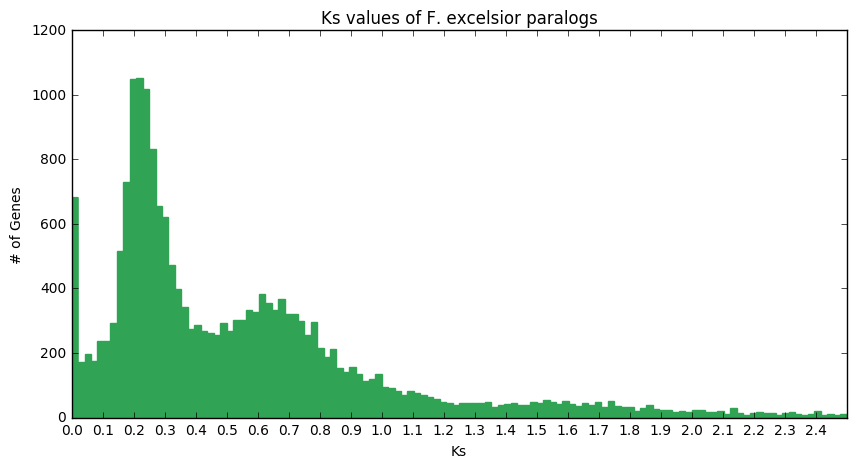

In [6]:

h = liz[liz['Ks'] < 2.5]['Ks'].hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel('Ks')
h.set_ylabel('# of Genes')
h.set_title('Ks values of F. excelsior paralogs')

# CAFE tree approximations

In [9]:
from newick import loads
import newick

all_trees = {}
with open(r"CAFE-4.2\data\all_species\reports\WGD_manual_all_species.cafe", 'r') as csvfile:
    lines = csvfile.readlines()[11:]
    for nLines, row in enumerate(lines):
        row = row.split('\t')
        all_trees[int(row[0])] = row[1]
len(all_trees)

ordered_names = loads('')[0]  # TODO: paste correct species tree
def create_ordered_nodes(verbose=False):
    ordered_nodes = []
    for node in ordered_names.walk(mode="preorder"):
        if verbose:
            print(node.name, node.length)
        ordered_nodes.append({'name': node.name, 'length':node.length, 'losses': 0, 'gains': 0, 'avg#': 0})
    return ordered_nodes
ordered_nodes = create_ordered_nodes()

In [4]:
def extract_count(name):
    if isinstance(name, newick.Node):
        name = name.name
    return int(name.split('_')[-1])

ordered_nodes[2]

def get_count_at_root(fam_id, ordered_node_index=2):
    newick_str = all_trees[fam_id]
    tree = loads(newick_str)[0]
    for index, node in enumerate(tree.walk(mode="preorder")):
        if index == ordered_node_index:
            count = extract_count(node)
            return count

In [9]:
#%%html
#<img src="all_species_node_labels_WGD_manual.png">

## Filter Families to Ones with a Duplication at Root < 55 > 

In [16]:
def populate_history_histogram(study_ints):
    ordered_nodes = create_ordered_nodes()
    genes_lost = {node['name']:set() for node in ordered_nodes}
    gene_gains = {node['name']:set() for node in ordered_nodes}
    for fam_id in study_ints:
        if fam_id not in all_trees:
            continue
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            tail = ''
            ordered_nodes[index]['avg#'] += count
            if node.ancestor:
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:
                    tail = ("loss")
                    ordered_nodes[index]['losses'] += 1 #parent_count - count
                    genes_lost[ordered_nodes[index]['name']].add(fam_id)  # record gene family
                elif count > parent_count:
                    tail = ("gain")
                    ordered_nodes[index]['gains'] += 1 #count - parent_count 
                    gene_gains[ordered_nodes[index]['name']].add(fam_id)
#             print(node.name, count, tail)
    for result in ordered_nodes:  # divide sum by length to get mean
        result['avg#'] /= len(study_ints)
    return ordered_nodes, genes_lost, gene_gains

study_ints = [int(fam[2:]) for fam in excelsior_orthogroups.keys()]
ordered_nodes, genes_lost, gene_gains = populate_history_histogram(study_ints)

In [17]:
len(gene_gains['<55>'])

5634

In [18]:
{key: len(val) for key, val in gene_gains.items()}

{'<11>': 25,
 '<13>': 29,
 '<15>': 24,
 '<17>': 49,
 '<19>': 30,
 '<1>': 36,
 '<21>': 71,
 '<23>': 10,
 '<25>': 2,
 '<27>': 0,
 '<29>': 19,
 '<31>': 31,
 '<33>': 7,
 '<35>': 43,
 '<37>': 39,
 '<39>': 24,
 '<3>': 44,
 '<41>': 17,
 '<43>': 43,
 '<45>': 72,
 '<47>': 22,
 '<49>': 83,
 '<51>': 43,
 '<53>': 0,
 '<55>': 5634,
 '<57>': 0,
 '<59>': 0,
 '<5>': 38,
 '<61>': 30,
 '<7>': 122,
 '<9>': 21,
 'FRAX00': 510,
 'FRAX01': 177,
 'FRAX03': 261,
 'FRAX04': 129,
 'FRAX05': 325,
 'FRAX06': 195,
 'FRAX07': 225,
 'FRAX08': 164,
 'FRAX09': 574,
 'FRAX11': 227,
 'FRAX12': 183,
 'FRAX13': 176,
 'FRAX14': 123,
 'FRAX15': 156,
 'FRAX16': 136,
 'FRAX19': 378,
 'FRAX20': 165,
 'FRAX21': 143,
 'FRAX23': 115,
 'FRAX25': 134,
 'FRAX26': 214,
 'FRAX27': 158,
 'FRAX28': 255,
 'FRAX29': 401,
 'FRAX30': 184,
 'FRAX31': 13,
 'FRAX32': 216,
 'FRAX33': 242,
 'Mguttatus': 484,
 'Oeuropea': 38,
 'Slycopersicum': 629,
 'empty': 0}

In [19]:
{key: len(val) for key, val in genes_lost.items()}

{'<11>': 367,
 '<13>': 457,
 '<15>': 877,
 '<17>': 1263,
 '<19>': 373,
 '<1>': 716,
 '<21>': 788,
 '<23>': 42,
 '<25>': 115,
 '<27>': 278,
 '<29>': 2658,
 '<31>': 582,
 '<33>': 502,
 '<35>': 941,
 '<37>': 260,
 '<39>': 1430,
 '<3>': 467,
 '<41>': 400,
 '<43>': 353,
 '<45>': 405,
 '<47>': 1188,
 '<49>': 382,
 '<51>': 543,
 '<53>': 118,
 '<55>': 0,
 '<57>': 3047,
 '<59>': 0,
 '<5>': 966,
 '<61>': 1422,
 '<7>': 701,
 '<9>': 31,
 'FRAX00': 1333,
 'FRAX01': 995,
 'FRAX03': 1870,
 'FRAX04': 2594,
 'FRAX05': 2280,
 'FRAX06': 2165,
 'FRAX07': 1995,
 'FRAX08': 3515,
 'FRAX09': 797,
 'FRAX11': 897,
 'FRAX12': 2482,
 'FRAX13': 2111,
 'FRAX14': 1793,
 'FRAX15': 2361,
 'FRAX16': 1992,
 'FRAX19': 1642,
 'FRAX20': 2966,
 'FRAX21': 3929,
 'FRAX23': 3288,
 'FRAX25': 3962,
 'FRAX26': 846,
 'FRAX27': 1519,
 'FRAX28': 1725,
 'FRAX29': 2610,
 'FRAX30': 1190,
 'FRAX31': 4901,
 'FRAX32': 1180,
 'FRAX33': 2318,
 'Mguttatus': 1633,
 'Oeuropea': 3192,
 'Slycopersicum': 1398,
 'empty': 8029}

## Combine Lizzy Ks and Node Count Criteria

In [20]:
def cafe_to_OG(cafe_id):
    return "OG" + '%07d' % (cafe_id)
assert cafe_to_OG(16622) =="OG0016622"

In [21]:
root_gains_families = set(cafe_to_OG(i) for i in gene_gains['<55>'])
len(root_gains_families)

5634

In [22]:
root_gain_genes = set()
for family in root_gains_families:
    root_gain_genes.update(excelsior_orthogroups[family]['genes'])
len(root_gain_genes)

274701

In [23]:
list(root_gain_genes)[:5]

['FRAX31_000004630.1_R0',
 'FRAX12_000275370.1_R0',
 'FRAX31_000009780.1_R0',
 'FRAX31_000356290.1_R0',
 'FRAX27_000355870.1_R0']

{gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [24]:
def gene_to_liz_row(gene):
    gene = gene.replace('FRAEX38873_v2_', '')
    ''.startswith()
    return liz
def liz_to_gene_name(row):
    row['Gene 1'] = 'FRAEX38873_v2_' + str(row['Gene 1']).zfill(11)
    row['Gene 2'] = 'FRAEX38873_v2_' + str(row['Gene 2']).zfill(11)
    return row
converted_liz = liz.apply(liz_to_gene_name, axis=1)
converted_liz.head()

,Group,Gene 1,Gene 2,Ks
0,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000342640.1,0.3768
1,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000254110.1,1.5491
2,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000083020.1,1.6002
3,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000254110.1,2.8645
4,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000083020.1,0.9481


In [25]:
filtered_rows = converted_liz['Gene 1'].isin(root_gain_genes)
sum(filtered_rows)

5424

In [26]:
filtered_rows = filtered_rows & (converted_liz['Gene 2'].isin(root_gain_genes))
sum(filtered_rows)

4510

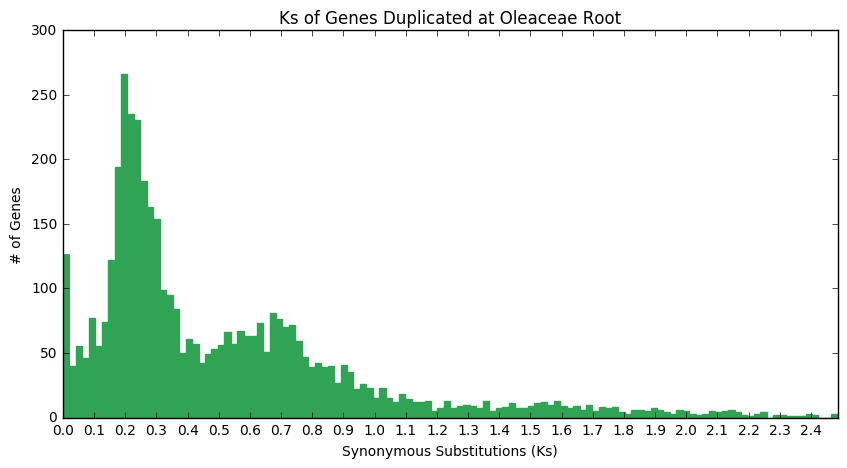

In [27]:
Ks_cap = converted_liz['Ks'] < 2.5
filtered_Ks = converted_liz[filtered_rows & Ks_cap]['Ks']
# pretty_hist("Ks of Genes Duplicated at Oleaceae Root", filtered_Ks, 
#             x_title="Synonymous Substitutions (Ks)", y_title="Number of Genes", bins = 120)

plt.xticks(np.arange(0, 2.6, .1))
h = filtered_Ks.hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel("Synonymous Substitutions (Ks)")
h.set_ylabel('# of Genes')
h.set_title("Ks of Genes Duplicated at Oleaceae Root")

**Conclusion** That looks the exact same as the population distribution.  Rooted copy number filtering was unsuccessful.  I need to switch datasets to a more recent simulations.  Homeologs may be necessary to make sure "gene family" doesn't diffuse the results too much.

In [28]:
%%html
<img src="CAFE-4.2/data/Ks values of F excelsior paralogs.png">

# Gene Tree Accounting with Duplications.csv

In [29]:
from collections import defaultdict
def Nx_counts_from_Duplications(dup_path, node_name):
    N1_counts = defaultdict(lambda: 0)
    from csv import DictReader
    orthogroups_seen = set()
    with open(dup_path,'r') as infile:
        lines = DictReader(infile, delimiter='\t')
#         print(lines.fieldnames)
        for line in lines:
            orthogroups_seen.add(line['Orthogroup'])
            if line['Species Tree Node'] == node_name:  # count mentions of N1
                N1_counts[line['Orthogroup']] += 1
    return N1_counts, orthogroups_seen

In [30]:
N1_counts, orthogroups_seen = Nx_counts_from_Duplications("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", 'N1')

In [31]:
heights = []
for i in range(1, 10):
    heights.append(len([og for og, c in N1_counts.items() if c == i]))
    print(i,       len([og for og, c in N1_counts.items() if c == i]))
print('All', len(N1_counts))

1 4242
2 2377
3 1256
4 680
5 350
6 194
7 125
8 85
9 57
All 9546


**Conclusion:** Still needs more thought.  You need an extra step between 0 and 1 duplication events to make the ratios line up for the first one:  Half of genes are duplicable.  Half of those actually get duplicated.  Half of those have N+1 duplications and so on.  Ratio might be different if we included the x > N tail instead of just the height of one bar.  CMF vs PDF essentially.  

------------

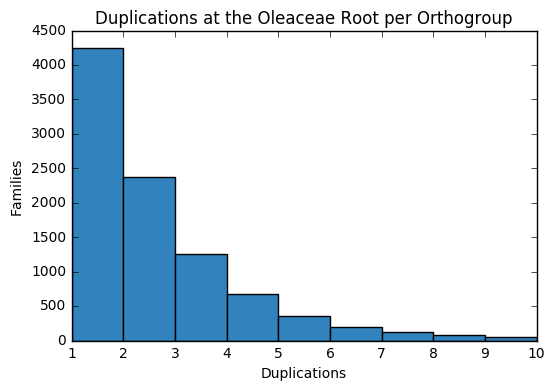

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import log
fig, ax = plt.subplots()
ax.bar([1,2,3,4,5,6,7,8,9], heights, width=1, color='#3182bd')
ax.set_title("Duplications at the Oleaceae Root per Orthogroup")
ax.set_xlabel("Duplications")
ax.set_ylabel("Families")

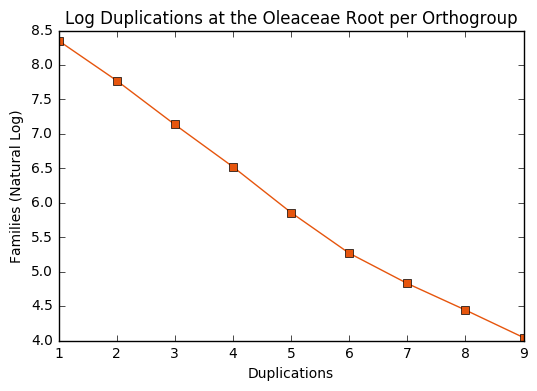

In [33]:
fig, ax = plt.subplots()
ax.plot([1,2,3,4,5,6,7,8,9], [log(h) for h in heights], 's-', color='#e6550d')
ax.set_title("Log Duplications at the Oleaceae Root per Orthogroup")
ax.set_xlabel("Duplications")
ax.set_ylabel("Families (Natural Log)")

In [34]:
ratios = []
for i, h in enumerate(heights):
    if i:
        print(round(h / heights[i-1] , 2))
        ratios.append(h / heights[i-1])
        if not h:
            break
import statistics
statistics.mean(ratios[:5])

0.56
0.53
0.54
0.51
0.55
0.64
0.68
0.67


0.5398277803614446

In [35]:
statistics.pstdev(ratios[:8])

0.06269242664855937

In [36]:
sum([h for h in heights])

9366

**Conclusion** That is eerily close to a perfectly straight line on the log scale.  The chance of seeing N+1 duplication events is a percentage of the previous number.

In [37]:
internal_mentions = defaultdict(lambda: 0)
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        if line['Species Tree Node'].startswith('N'):  # count mentions of anything not a species
            internal_mentions[line['Orthogroup']] += 1

len(internal_mentions)

16371

In [38]:
OG_names = set()
with open("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv",'r') as infile:
    lines = DictReader(infile, delimiter='\t')
    for line in lines:
        OG_names.add(line['Orthogroup'])
len(OG_names)

19118

**Conclusion** 85% of OGs with a duplication have an internal duplication.  49.9% of them mention N1.  22% have one duplication there, 2377+4242 = 34% of them have 1 or 2 duplications at N1.  There's still twice as many with 1 than 2.  I would need Jasmine to separate the two categories.  

# Separate out Study Homeologs into pairs of trees

In [39]:
study_homeologs = [og for og, c in N1_counts.items() if c == 1]
len(study_homeologs), study_homeologs[:5]

(4242, ['OG0012812', 'OG0010734', 'OG0006600', 'OG0005053', 'OG0003532'])

' '.join(study_homeologs)

*Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Recon_Gene_Trees\212_count_scrap.tre*  
A vs B subtrees after a duplication are defined in the "Genes 1" and "Genes 2" columns of Duplications.csv. The "Gene Tree Node" seems nonsensical, but the number and names of listed genes correspond to actual subtrees.

In [47]:
from shutil import copy
import os
from os.path import splitext, basename
os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul04_2')

## Rename every text file to a .tre file
from glob import glob
for f in glob('Gene_Trees/*.txt'):
    os.rename(f, 'Gene_trees/'+splitext(basename(f))[0]+'.tre')
    
for f in glob('Recon_Gene_Trees/*.txt'):
    os.rename(f, 'Recon_Gene_trees/'+splitext(basename(f))[0]+'.tre')

## Splitting into pairs of sets of genes following the WGD

In [81]:
def append_the_first_row(fam_id, split_families, df, node_name):
    focus = df[(df['Orthogroup'] == fam_id) & (df['Species Tree Node'] == node_name)]
    row = next(focus.iterrows())[1]
    og = row['Orthogroup']
    split_families['1' + og[2:]] = row['Genes 1'].split(', ')
    split_families['2' + og[2:]] = row['Genes 2'].split(', ')

def collect_all_Nx_duplicated_genes(df, Nx_counts, node_name):
    any_N1_duplicates = [k for k,v in Nx_counts.items() if v > 0]
    split_families = {}  # could be output as files
    for fam_id in any_N1_duplicates:
        append_the_first_row(fam_id, split_families, df, node_name)
    print(len(split_families))
    return split_families


In [100]:
import os
from collections import defaultdict
from pandas import read_csv
def duplications_count_by_node(species_node, dup_path, rows):
    N_counts = defaultdict(lambda: 0)
    os.chdir(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications')
    for index, line in rows[rows['Species Tree Node'] == species_node].iterrows():
        og = line['Orthogroup']
        N_counts[og] += 1
    study_homeologs = [og for og, c in N_counts.items() if c == 1]
    

    all_splits = collect_all_Nx_duplicated_genes(rows, N_counts, species_node)
    print('Found', len([k for k,v in N_counts.items() if v > 0])*2, 'subtrees')
    print('Using', len(study_homeologs)*2, 'subtrees')
    return study_homeologs, N_counts, all_splits



In [101]:
from pandas import DataFrame, Series
def format_table(split_families, convert_fam_id=False):
    def species_count_from_subtree(subtree):
        assert hasattr(subtree, '__iter__')
        sub_counts = defaultdict(lambda: 0)
        for gene in subtree:
            sub_counts[gene.split('_')[0]] += 1
        assert sum(sub_counts.values()) == len(subtree)
        return sub_counts
    data = {}
    for name, subfamily in split_families.items():
        sub_counts = species_count_from_subtree(subfamily)
        data[name] = sub_counts
    df = DataFrame.from_dict(data, orient='index', )
    df.fillna(value=0, inplace=True)
    df = df.astype(int)
    df.index.name = 'Desc'
    if convert_fam_id:
        df['Family ID'] = df.apply(lambda row: str(row.name)[-1:] + str(row.name)[2:-2], axis=1) # e.g. OG0000212_1 => 10000212
    else:
        df['Family ID'] = df.apply(lambda row: row.name, axis=1)

    column_order = ['Family ID'] + sorted('Oeuropea	FRAX08	FRAX05	FRAX25	FRAX14	FRAX15	FRAX32	FRAX21	FRAX33	FRAX26	FRAX16	FRAX03	FRAX07	FRAX23	FRAX31	FRAX09	FRAX19	FRAX12	FRAX29	FRAX01	FRAX00	FRAX13	FRAX20	FRAX30	FRAX27	FRAX04	FRAX11	FRAX28	FRAX06'.split('\t'))
#     column_order.remove('FRAX02')
#     column_order.remove('FRAX34')
    df = df[column_order]
    return df

In [104]:
def split_subtrees(target_species_node, duplications_path):
    rows = read_csv(duplications_path, delimiter='\t')
    study_homeologs, N_counts, all_splits = duplications_count_by_node(target_species_node, duplications_path, rows)
    split_families = {}
    
    #all_splits_table = format_table(all_splits)
    #all_splits_table.head()
    #all_splits_table.to_csv(r'CAFE-4.2\data\corrected_orthologs\all_N1_duplication_counts.csv', sep='\t')
    study_rows = rows[rows['Orthogroup'].isin(study_homeologs) & (rows['Species Tree Node'] == target_species_node)]
    def final_split():
        for index, row in study_rows.iterrows():
            og = row['Orthogroup']
            split_families[og + '_1'] = row['Genes 1'].split(', ')
            split_families[og + '_2'] = row['Genes 2'].split(', ')
    print(pp(sum([len(v) for v in split_families.values()])), 
          "Total Genes included in the study, separated over", 
          pp(len(split_families)), "gene families")
    return split_families

Feb05 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb05\Duplications.csv"
study_homeologs, N2_counts, subtrees_Feb5 = split_subtrees('N2', Feb05)

10520
Found 10520 subtrees
Using 3232 subtrees
0 Total Genes included in the study, separated over 0 gene families


ValueError: need more than 0 values to unpack

96,778 Total Genes included in the study, separated over 3,204 gene families


In [98]:
#TODO Double check with original Jul04 dataset to see if we still get 8484 families
#N1_counts, orthogroups_seen = Nx_counts_from_Duplications("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", 'N1')

Peel off first part of gene name for species count

In [59]:
gene_set = set()
gene_set.update(*(v for v in split_families.values()))
len(gene_set)

96778

In [60]:
unique_starts = set(gene.split('_')[0] for gene in gene_set)
unique_starts

{'FRAX00',
 'FRAX01',
 'FRAX02',
 'FRAX03',
 'FRAX04',
 'FRAX05',
 'FRAX06',
 'FRAX07',
 'FRAX08',
 'FRAX09',
 'FRAX11',
 'FRAX12',
 'FRAX13',
 'FRAX14',
 'FRAX15',
 'FRAX16',
 'FRAX19',
 'FRAX20',
 'FRAX21',
 'FRAX23',
 'FRAX25',
 'FRAX26',
 'FRAX27',
 'FRAX28',
 'FRAX29',
 'FRAX30',
 'FRAX31',
 'FRAX32',
 'FRAX33',
 'FRAX34',
 'Oeuropea'}

In [61]:
[gene for gene in gene_set if not gene.startswith('FRAX') and not gene.startswith('Oeuropea')]

[]

**Conclusion:** There are no Solanum or Erythranthe genes in these subtrees.  That was probably an implicit criteria of their selection.  Is this a problem?  Since I'm retaining the original OG names, we can always cross reference the included subtrees and the excluded subtrees (which would contain Solanum and Erythranthe).

*TODO: Pull OG out of Orthogroups.csv and remove the genes listed in "Genes 1" and "Genes 2" (also in gene_set) and save this as OG#####_out.*

In [62]:
df = format_table(split_families).head()

df.to_csv(r'CAFE-4.2\data\homeologs_only\homeolog_counts.txt', sep='\t')

In [63]:
df.head()

,Family ID,FRAX00,FRAX01,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,FRAX09,...,FRAX25,FRAX26,FRAX27,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,Oeuropea
Desc,,,,,,,,,,,,,,,,,,,,,
OG0000013_1,OG0000013_1,1,1,1,1,1,2,2,1,1,...,1,0,1,1,2,2,1,1,2,1
OG0000013_2,OG0000013_2,3,3,1,1,2,2,1,1,2,...,2,2,1,1,1,1,2,1,1,0
OG0000057_1,OG0000057_1,1,1,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,1,1,1
OG0000057_2,OG0000057_2,2,11,8,8,10,6,9,8,10,...,2,6,9,12,10,10,1,11,6,0
OG0000069_1,OG0000069_1,2,6,9,8,9,6,10,8,9,...,9,8,9,9,8,11,9,8,9,1



# Feb 05 Analysis Using Corrected Outgroup Reconciled Gene Trees

Previous studies were done with Orthogroups made with all species (FRAX02 and FRAX34) but also the wrong relationship between Solanum and Mimmulus (Eryanthre).  Having corrected that, the species tree that gene trees are reconciled to also need to be updated.  
* The node might not be called N1 anymore
    * Based on the labeling of nodes from the same program I expect **the species tree Oleaceae to be N2**
* We should still filter for 1 split at the WGD per gene tree
* Still take the left and right subtrees and discard the rest of the gene tree outside those two subtrees.  That ensure we're comparing gene pairs of equal age from the same event.  
* Technically every pairwise combination across (but not within) the two subtrees should be a valid Ks and 4DTv


In [64]:
Feb05 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb05\Duplications.csv"
N2_counts, orthogroups_N2_seen = Nx_counts_from_Duplications(Feb05, node_name='N2')

In [65]:
dups_df = read_csv(Feb05, delimiter='\t')

In [66]:
dups_df[dups_df['Orthogroup'] == 'OG0003492'].head()

,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
45502,OG0003492,N0,n0,0.060606,Shared,"Slycopersicum_Solyc05g055020.2.1, Slycopersicu...","Slycopersicum_Solyc06g082210.1.1, Oeuropea_OE6..."
45503,OG0003492,Slycopersicum,n2,1.000000,Terminal,Slycopersicum_Solyc05g055020.2.1,Slycopersicum_Solyc04g009980.2.1
45504,OG0003492,N2,n5,1.000000,Shared,"Oeuropea_OE6A096146P1, FRAX08_FRAX08_000398260...","Oeuropea_OE6A064601P1, Oeuropea_OE6A088529P1, ..."
45505,OG0003492,Oeuropea,n39,1.000000,Terminal,Oeuropea_OE6A064601P1,Oeuropea_OE6A088529P1
45506,OG0003492,Mguttatus,n69,1.000000,Terminal,Mguttatus_Migut.H01303.1.p,Mguttatus_Migut.D00854.1.p


In [67]:
N1_counts['OG0003492']

1

**GOAL:** Test to what degree N1_counts and N2_counts differ.  
* Given a group of N1_counts that are all 1, their average in N2 counts should be close to 1.
* Given a different Species tree node, the results should be more divergent than 3%

| Results | Average |
| ----------- | ----------- |
| N0    | 0.11621876473361623 |
| N1    | 0.11291843470061291  |
| **N2** | **0.9707685054219708**  |
| N3    | 0.5044790193305044|
| N4    | 0.4941065535124941|

* Results strongly support that N2 is the species node and that results are largely unchanged ~3%

In [68]:
from statistics import mean
N2_compare = [N2_counts[og] for og in study_homeologs]
mean(N2_compare)

1.0

N0_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N0')
mean([N0_counts[og] for og in study_homeologs])

N3_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N3')
mean([N3_counts[og] for og in study_homeologs])

Nx_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N1')
mean([Nx_counts[og] for og in study_homeologs])

N4_counts, ignored = Nx_counts_from_Duplications(Feb05, node_name='N4')
mean([N4_counts[og] for og in study_homeologs])

-------------------------------
### Test for overlap in OG names

In [77]:
study_homeologs = set(study_homeologs)
len(study_homeologs) # from incorrect species tree

1616

In [78]:
refined_ohnologs = {og for og in N2_counts if N2_counts[og] == 1}
len(refined_ohnologs), pp(len(refined_ohnologs) / len(study_homeologs))

(1616, '100.000000%')

In [75]:
len(refined_ohnologs.intersection(study_homeologs)) / 4075  # Agreement overlap

0.39656441717791413

In [79]:
len(refined_ohnologs.difference(study_homeologs)) / 4075

0.0

#### Conclusion: 97% overlap means the difference would be negligible
-------------------------------
### Test if the same gene Names would have been used in left-right subtrees for Ohnologs

In [91]:
def gene_set_from_Duplications_csv(path, node_name):
    counts, ignored = Nx_counts_from_Duplications(path, node_name=node_name)
    print("Done collecting", len(counts), "counts")
    df = read_csv(path, delimiter='\t')
    splits = collect_all_Nx_duplicated_genes(df, counts, node_name)
    print("Identified", len(splits), "valid ohnolog tree splits")
    gene_set = set()
    for v in splits.values():
        gene_set.update(v)
    print(len(gene_set), "ohnolog genes identified")
    return gene_set, splits

In [92]:
Jul04 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv" 
Jul04_set, Jul04_splits = gene_set_from_Duplications_csv(Jul04, 'N1')

Done collecting 9546 counts
19092
Identified 19092 valid ohnolog tree splits
579487 ohnolog genes identified


In [93]:
revised_splits = collect_all_Nx_duplicated_genes(dups_df, N2_counts, 'N2')

10520


In [94]:
pp(len(Jul04_splits) / len(revised_splits))

'181.482890%'

In [84]:
def first(iterable):
    if isinstance(iterable, dict):
        return next(iter(iterable.items()))
    return next(iter(iterable))

In [89]:
#Virutally identical sets of keys
pp(len(set(revised_splits.keys()).intersection(Jul04_splits.keys())) / 18712)

'100.000000%'

In [86]:
from itertools import chain
revised_gene_set = set()
for v in revised_splits.values():
    revised_gene_set.update(v)
first(revised_gene_set)

'FRAX02_FRAX02_000081500.1_R0'

In [87]:
original_gene_set = set()
for v in all_splits.values():
    original_gene_set.update(v)
pp(len(original_gene_set) / len(revised_gene_set)    )

'100.000000%'

In [88]:
pp( len(revised_gene_set.intersection(original_gene_set))/ len(original_gene_set))

'100.000000%'

#### Final conclusion: revised_gene_set with corrected outgroup species tree yields nearly identical results.  There's no need to change downstream analysis or doubt the membership of Ohnologs

## Testing Determinism of Gene Tree Reconciliation
corrected_homeologs.sh was run two more times, yielding Feb05, Feb08, and Feb12 that were all run under **exactly** the same parameters.  Differences in these results are due to non-determinism of the algorithm.

In [ ]:
Jul04 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv" 
Jul04_set, Jul04_splits = gene_set_from_Duplications_csv(Jul04, 'N1')

In [ ]:
Feb05 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb05\Duplications.csv"
Feb05_set, Feb05_splits = gene_set_from_Duplications_csv(Feb05, 'N2')

In [ ]:
Feb08 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb08\Duplications.csv"
Feb08_set, Feb08_splits = gene_set_from_Duplications_csv(Feb08, 'N2')

In [ ]:
Feb12 = r"Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\New_Analysis_From_Trees_Feb12\Duplications.csv"
Feb12_set, Feb12_splits = gene_set_from_Duplications_csv(Feb12, 'N2')

In [ ]:
def overlap_geneset_statistics(setA, setB):
#     pp(len(all_splits) / len(revised_splits))
#     pp(len(set(revised_splits.keys()).intersection(all_splits.keys())) / 18712)
    longer = max(len(setB), len(setA))
    print("Lengths are", pp(min(len(setA), len(setB)) / longer), "of the longer one")
    print("Gene intersection is", pp( len(setA.intersection(setB))/ longer),"of the longer one")
overlap_geneset_statistics(Jul04_set, Feb05_set)

In [ ]:
overlap_geneset_statistics(Feb08_set, Feb05_set)

In [ ]:
overlap_geneset_statistics(Feb08_set, Feb12_set)

In [ ]:
overlap_geneset_statistics(Feb05_set, Feb12_set)

In [ ]:
overlap_geneset_statistics(Jul04_set, Feb08_set)

In [ ]:
overlap_geneset_statistics(Jul04_set, Feb12_set)

**Conclusion: Gene tree reconciliation is non-deterministic.  However Jul04 set is an outlier at 97% overlap instead of 99.8% overlap.  That's a 15x larger difference than between technical replicates.**

In [ ]:
species_names = set()
for i, name in enumerate(Feb12_set):
    if i > 1000:
        break
    species_names.add(name[:6])
species_names

### Print gene list for Ks plots

In [ ]:
with open(r'CAFE-4.2\data\homeologs_only\original_gene_set_ohnologs.csv', 'w') as f:
    for g in original_gene_set:
        f.write(g + '\n')

In [ ]:
len(original_gene_set)

In [ ]:
revised_splits['10004658']

# Dill Session Save / Load

##  Save a Notebook session:
import dill
dill.dump_session('Homeologs_Analysis.db')

Restore a Notebook session:
import dill
dill.load_session('Homeologs_Analysis.db')